In [83]:
import pickle
import sys, os
sys.path.append(os.pardir) 
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

<br><hr><br>

## 1) Two-Layer Neural Net with backward propagation

In [2]:
class ReLU : 
    def __init__(self) : 
        self.mask = None
        
    def forward(self, x) : 
        self.mask = (x<=0) #numpy 배열 x와 같은 shape을 가진 배열을 만들고, 0 이상인 셀은 True, 0 미만인 셀은 False인 배열을 반환
        out = x.copy() 
        out[self.mask] = 0 #numpy 배열인 x 중 0 이하인 값은 0으로 치환
        return out
    
    def backward(self, dout) : 
        dout[self.mask] = 0 #numpy 배열 dout 중 0 이하인 값은 0으로 치환
        dx = dout
        return dx

In [3]:
class Affine : 
    def __init__(self, W, b) : 
        self.W = W 
        self.b = b 
        self.x = None
        self.dW = None
        self.db = None
        
    
    def forward(self, x) : 
        self.x = x 
        out = np.dot(x, self.W) + self.b
        return out
    
    
    def backward(self, dout) : 
        dx = np.dot(dout, self.W.T) 
        self.dW = np.dot(self.x.T, dout) 
        self.db = np.sum(dout, axis=0)
        return dx

In [4]:
#softmax_function
def softmax_function(x) : 
    max_by_row = np.amax(x, axis=1)
    max_by_row = np.reshape(max_by_row, [max_by_row.shape[0],1])
    nom = np.exp(x-max_by_row)
    denom = np.sum(np.exp(x-max_by_row), axis=1)
    denom = np.reshape(denom, [denom.shape[0],1])
    return nom/denom

In [95]:
def get_mini_batch(x, y, i, batch_size) : 
    if i+batch_size >= len(x) :
        x_batch = x[i*batch_size:len(x)] #마지막 부분은 예외처리 (list index range)
        y_batch = y[i*batch_size:len(y)]
    else : 
        x_batch = x[i*batch_size:(i+1)*batch_size] 
        y_batch = y[i*batch_size:(i+1)*batch_size] 
    
    return x_batch, y_batch

In [5]:
#CEE (cross_entropy_error, 교차엔트로피오차)
def CEE(y_p, y_t) : #y_p: predicted vector, y_t: actual_vector
    if y_t.ndim == 1 : 
        y_t = y_t.reshape(1, y_t.size)
        y_p = y_p.reshape(1, y_p.size)
        
    delta = 1e-7
    return -1/y_p.shape[0]*np.sum(y_t*np.log(y_p + delta)) #y_p가 0이 되어 log 계산시 -inf가 나오는 현상 방지

In [6]:
def weight_numerical_gradient(f, x) : #편미분은 특정 변수에 대한 미분을 의미했는데, 
    #gradient는 각각의 변수에 대해 전부 편미분하여 그 값을 numpy array형태로 반환한다. 실제 내부 코드는 partial_diff와 크게 다르지 않다.
    h = 1e-4 #0.0001
    grad = np.zeros_like(x)

    for i in range(0, x.shape[0]) : 
        for j in range(0, x.shape[1]) : 
            temp = x[i][j]

            x[i][j] = temp + h
            fxh1 = f(x[i][j])
            x[i][j] = temp - h 
            fxh2 = f(x[i][j])

            grad[i][j] = (fxh1-fxh2)/(2*h)
            x[i][j] = temp

    return grad

In [7]:
#ㅜnumerical differentian function for bias (수치 미분 함수)
def bias_numerical_gradient(f, x) : #편미분은 특정 변수에 대한 미분을 의미했는데, 
    #gradient는 각각의 변수에 대해 전부 편미분하여 그 값을 numpy array형태로 반환한다. 실제 내부 코드는 partial_diff와 크게 다르지 않다.
    h = 1e-4 #0.0001
    grad = np.zeros_like(x)

    for i in range(0, x.shape[0]) : 
        temp = x[i]

        x[i] = temp + h
        fxh1 = f(x[i])
        x[i] = temp - h 
        fxh2 = f(x[i])

        grad[i] = (fxh1-fxh2)/(2*h)
        x[i] = temp

    return grad

In [8]:
class SoftmaxWithLoss : 
    def __init__(self) : 
        self.loss = None #최종 결과물인 loss값
        self.y = None #predicted Y
        self.t = None #actual Y
        
    
    def forward(self, x, t) : 
        self.t = t
        self.y = softmax_function(x)
        self.loss = CEE(self.y, self.t)
        return self.loss
    
    
    def backward(self, dout=1) : 
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [9]:
class TwoLayerNet : 
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01) : 
        #weight initialization 
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size) #random.randn은 음수 포함한 랜덤 실수 생성
        self.params["b1"] = np.zeros(hidden_size) 
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params["b2"] = np.zeros(output_size)
        
        #Layers 
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["ReLU1"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()
        
        
    def predict(self, x) : 
        for layer in self.layers.values() : 
            x = layer.forward(x)
        return x
    
    
    #x: input_data, t: label
    def loss(self, x, t) : 
        y = self.predict(x) 
        return self.lastLayer.forward(y, t)
    
    
    #x: input_data, t: label
    def accuracy(self, x, t) : 
        y = self.predict(x) 
        y = np.argmax(y, axis=1) 
        if t.ndim != 1 : #1d vector가 아니라 one-hot된 2d matrix라면 argmax를 이용해 1d vector로 변환한다.
            t = np.argmax(t, axis=1)
            
        accuracy = np.sum(y==t) / float(x.shape[0]) # 평균 오차 = (y_t - y_p)/batch_size
        return accuracy
    
    
    #x: input_data, t: label
    def numerical_gradient(self, x, t) : 
        loss_W = lambda W: self.loss(x, t) 
        
        grads = {}
        grads["W1"] = weight_numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = bias_numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = weight_numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = bias_numerical_gradient(loss_W, self.params["b2"])
        
        return grads
    
    
    def gradient(self, x, t) : 
        #forward propagation
        self.loss(x, t) 
        
        #backward propagation
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers : 
            dout = layer.backward(dout)
            
        #save result
        grads = {}
        #self.layers.values()를 forward & backward하면서 클래스 변수인 dW와 db가 없데이트되었다.
        grads["W1"] = self.layers["Affine1"].dW 
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads

<br><hr><br>

## 2) Comparing computational time of numerical gradient and backward propagation

In [49]:
#mnist 데이터 pickle로 로드
temp = []

with open("mnist_dataset.txt", mode="rb") as fp : 
    temp = pickle.load(fp)
    temp[0] = np.reshape(temp[0], [temp[0].shape[0], -1])
    temp[2] = np.reshape(temp[2], [temp[2].shape[0], -1])
    
    nb_classes = 10
    temp[1] = np.array([temp[1]]).reshape(-1)
    temp[1] = np.eye(nb_classes)[temp[1]]
    temp[3] = np.array([temp[3]]).reshape(-1)
    temp[3] = np.eye(nb_classes)[temp[3]]
    
x_train, y_train, x_test, y_test = temp

In [11]:
network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=10)

In [12]:
x_batch = x_train[:3]
y_batch = y_train[:3]

In [16]:
grad_numerical = network.numerical_gradient(x_batch, y_batch)

In [17]:
grad_backprop = network.gradient(x_batch, y_batch)

In [15]:
for key in grad_numerical.keys() : 
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key])) #평균오차
    print(key + ":" + str(diff))

W1:6.60072109351e-07
b2:7.34884831302e-07
b1:1.78445486616e-08
W2:6.42350624041e-06


### => There is no significant difference between two, but backprop is much faster than numerical gradient

<br><hr><br>

## 3) Stochastic Gradient Descent

In [65]:
class SGD :
    def __init__(self, lr=0.01) : 
        self.lr = lr
        
    def update(self, params, grads) : 
        for key in params.keys() : 
            params[key] -= self.lr * grads[key]
        
        return params

In [75]:
network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=10)
optimizer = SGD()
batch_size = 32

In [91]:
accuracy_list = []
for i in range(1000) : 
    x_batch, t_batch = get_mini_batch(x_train, y_train, i, batch_size)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    network.params = optimizer.update(params, grads)
    accuracy_list.append(network.accuracy(x_test, y_test))

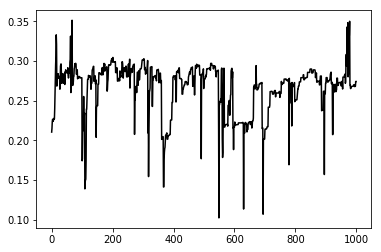

In [96]:
plt.figure()
plt.plot(accuracy_list, color="black")
plt.show()

<br><hr><br>

## 4) Momentum

In [110]:
class Momentum : 
    def __init__(self, lr=0.01, momentum=0.9) : #momentum means 'alpha' which controll v's ratio to pass next epoch
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads) : 
        if self.v is None : 
            self.v = {}
            for key, val in params.items() : 
                self.v[key] = np.zeros_like(val) 
        
        for key in params.keys() : 
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]
            
        return params

In [111]:
network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=10)
optimizer = Momentum()
batch_size = 32

In [112]:
accuracy_list = []
for i in range(1000) : 
    x_batch, t_batch = get_mini_batch(x_train, y_train, i, batch_size)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    network.params = optimizer.update(params, grads)
    accuracy_list.append(network.accuracy(x_test, y_test))

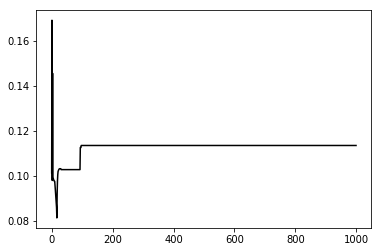

In [114]:
plt.figure()
plt.plot(accuracy_list, color="black")
plt.show()

<br><hr><br>

## 5) AdaGrad

In [120]:
class AdaGrad : 
    def __init__(self, lr=0.01) : 
        self.lr = lr
        self.h = None
        
    def update(self, params, grads) : 
        if self.h is None : 
            self.h = {}
            for key, val in params.items() : 
                self.h[key] = np.zeros_like(val) 
                
        for key in params.keys() : 
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
        return params

In [121]:
network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=10)
optimizer = AdaGrad()
batch_size = 32

In [122]:
accuracy_list = []
for i in range(1000) : 
    x_batch, t_batch = get_mini_batch(x_train, y_train, i, batch_size)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    network.params = optimizer.update(params, grads)
    accuracy_list.append(network.accuracy(x_test, y_test))

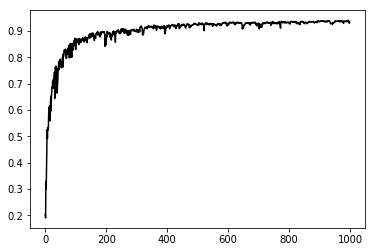

In [123]:
plt.figure()
plt.plot(accuracy_list, color="black")
plt.show()

<br><hr><br>

## 6) Adam

In [128]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
            
        return params

In [129]:
network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=10)
optimizer = Adam()
batch_size = 32

In [130]:
accuracy_list = []
for i in range(1000) : 
    x_batch, t_batch = get_mini_batch(x_train, y_train, i, batch_size)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    network.params = optimizer.update(params, grads)
    accuracy_list.append(network.accuracy(x_test, y_test))

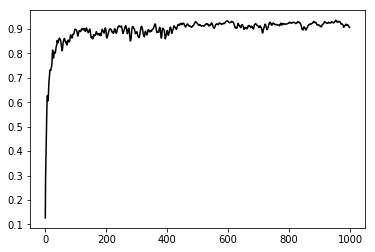

In [131]:
plt.figure()
plt.plot(accuracy_list, color="black")
plt.show()

<br><hr><br>